In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
num_data = {
    'netifier': 7773,
    'dat': 500,
    'hsd': 13169,
    'casa': 1080,
    'hoasa': 2854,
}

In [19]:
def average_results(results):
    mean_results = pd.concat(results).groupby(level=0).mean()
    std_results = pd.concat(results).groupby(level=0).std()
    return mean_results, std_results

def plot_results(dataset, result, metric='F1 Micro'):
    data_used = [round(x / num_data[dataset] * 100, 0) for x in result['mc-kfold']['Data Used']]
    plt.figure(figsize=(15, 10))

    for method in result.keys():
        if method != 'passive-kfold':
            plt.plot(data_used, result[method][metric], label=method.upper(), marker='o')
        elif metric != 'Sampling Duration':
            plt.plot(data_used, result[method][metric], label=method.upper(), linestyle='--', color='black')

    plt.title(dataset.upper())
    plt.xlabel("Data Used (%)")
    plt.ylabel(metric)
    plt.legend(fontsize='x-large')
    plt.grid(True, axis='x')

    plt.xticks(data_used)
    plt.tight_layout()
    plt.show()

In [20]:
def load_result(dataset, ignored_method=None):
    methods = ['lc-kfold', 'mc-kfold', 'kmeans-kfold', 'coreset-kfold', 'comal-kfold', 'besra-kfold', 'random-kfold']
    result = {}

    if ignored_method is not None:
        for method in ignored_method:
            methods.remove(method)
    
    for method in methods:
        for i in range (1, 6):
            if i == 1:
                result[method] = [pd.read_csv(f"../{dataset}/metrics/{dataset}-{method}-{i}-results.csv")]
            else:
                result[method].append(pd.read_csv(f"../{dataset}/metrics/{dataset}-{method}-{i}-results.csv"))

    for method in methods:
        result[method], std = average_results(result[method])
        print(f"{method.upper()} STD: {std['F1 Micro'].mean()}")
        print(result[method])
        print("-" * 50)

    
    passive_result = pd.read_csv(f"../{dataset}/metrics/{dataset}-passive-kfold-results.csv")
    print("-" * 50)
    print("Passive Avg", np.mean(passive_result['F1 Micro']))
    result['passive-kfold'] = pd.DataFrame({
        'Accuracy': [np.mean(passive_result['Accuracy']) for i in range(len(result['mc-kfold']))],
        'F1 Micro': [np.mean(passive_result['F1 Micro']) for i in range(len(result['mc-kfold']))],
        'F1 Macro': [np.mean(passive_result['F1 Macro']) for i in range(len(result['mc-kfold']))],
    })

    return result

In [21]:
def highlight_cells(val):
    if val > 0: 
        return 'background-color:lightgreen;color:black'
    elif val < 0:
        return 'background-color:lightcoral;color:black'
    else:
        return 'background-color:lightyellow;color:black'

def compare_results(result, num_data, key, benchmark_type='random', tolerance=0, checkpoint_only=False, ignored_method=None):
    results = {}
    index = []

    if benchmark_type == 'random':
        benchmark = result[benchmark_type][~result[benchmark_type]['Data Used'].astype(int).isin([9216, 9217])]
        benchmark = benchmark[key].values
    else:
        benchmark = result['passive-kfold'][key].values[0] - tolerance

    diff = {}

    for method in result.keys():
        if benchmark_type == 'random' and method == 'random-kfold':
            continue
        if (ignored_method is not None and method in ignored_method) or method == 'passive-kfold':
            continue

        filtered = result[method][~result[method]['Data Used'].astype(int).isin([9216, 9217])]
        if checkpoint_only:
            index = []
            for i in range(len(filtered[key])):
                if round(filtered['Data Used'].iloc[i] / num_data, 2) in [0.50, 0.60, 0.70, 0.80]:
                    index.append(i)

            if benchmark_type == 'passive':
                results['passive-kfold'] = [0 for i in range(len(filtered['Data Used']))]
            results[method] = 100 * (filtered[key].iloc[index].values - benchmark) / benchmark
            index = np.round(result['lc']['Data Used'].iloc[index].values / num_data * 100, 1)
        else:
            if not benchmark_type == 'passive':
                # significant_diffs = filtered.copy()
                # significant_diffs = filtered[round(filtered['Data Used'] / num_data <= 0.60, 2)]
                # diff[method] = (100 * (significant_diffs[key].values - benchmark[:significant_diffs.shape[0]]) / benchmark[:significant_diffs.shape[0]]).mean()
                diff[method] = (100 * (filtered[key].values - benchmark[:filtered.shape[0]]) / benchmark[:filtered.shape[0]]).mean()
            
            results[method] = 100 * (filtered[key].values - benchmark)
            index = np.round(filtered['Data Used'].values / num_data * 100, 1)

    if (benchmark_type == 'random'):
        print("Mean Diff:", diff)
            
    df = pd.DataFrame(results, index=index)
    return df

In [22]:
def plot_tabular_result(df, dataset, title='Δ F1 Micro', ignored_method=None):
    plt.figure(figsize=(12, 8))

    methods = ['LC', 'MC Dropout', 'KMeans', 'Coreset', 'CoMAL', 'BESRA', 'Random']
    methods = [method for method in methods if method not in ignored_method]

    # Create mask for positive and negative values
    mask_neg = df < 0
    mask_pos = df >= 0

    # Initialize the heatmap with labels at the top
    ax = sns.heatmap(df, cmap='Greys', cbar=False, annot=False, linewidths=0.5, 
                    xticklabels=df.columns, yticklabels=df.index)

    ax.xaxis.tick_top()
    ax.set_ylabel('Data Used (%)')
    ax.set_yticklabels([f"{round(val, 0):.0f}%" for val in df.index])
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticklabels(methods)

    # Apply red color to negative values and green to positive values
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            if mask_neg.iloc[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='lightcoral', alpha=0.9))
            elif mask_pos.iloc[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='lightgreen', alpha=0.9))

    # Format annotations with percentage sign
    annotations = df.map(lambda x: f"{x:.2f}%")

    # Add annotations with black text color
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            text = plt.text(j + 0.5, i + 0.5, annotations.iloc[i, j],
                        ha="center", va="center", color="black", fontweight='normal')

    plt.title(f'{title} ({dataset})', fontsize=14, pad=40)
    plt.tight_layout()
    plt.show()

# HATE SPEECH DETECTION

LC-KFOLD STD: 0.010274151570423678
    Data Used  Accuracy  F1 Micro  F1 Macro
0       658.0  0.878286  0.587577  0.293711
1      1646.0  0.877139  0.614080  0.319749
2      2535.0  0.878416  0.627161  0.336548
3      3335.2  0.882614  0.655011  0.386170
4      4055.2  0.886006  0.668876  0.394792
5      4703.2  0.891729  0.685678  0.441615
6      5287.2  0.900000  0.702988  0.465990
7      5812.2  0.904898  0.723804  0.499865
8      6285.2  0.907800  0.730736  0.529156
9      6584.0  0.910181  0.739348  0.573660
10     6980.0  0.915079  0.749236  0.591758
11     7336.0  0.914689  0.753262  0.600435
12     7656.0  0.917572  0.760666  0.611749
13     7901.0  0.917770  0.763668  0.611108
14     8165.0  0.919271  0.764329  0.615821
15     8402.2  0.920089  0.768182  0.621860
16     8616.2  0.920926  0.769301  0.623882
17     8816.2  0.922228  0.772410  0.625948
18     9016.2  0.922166  0.774184  0.627268
19     9216.2  0.921999  0.774227  0.628689
20     9218.0  0.921633  0.775313  0.6366

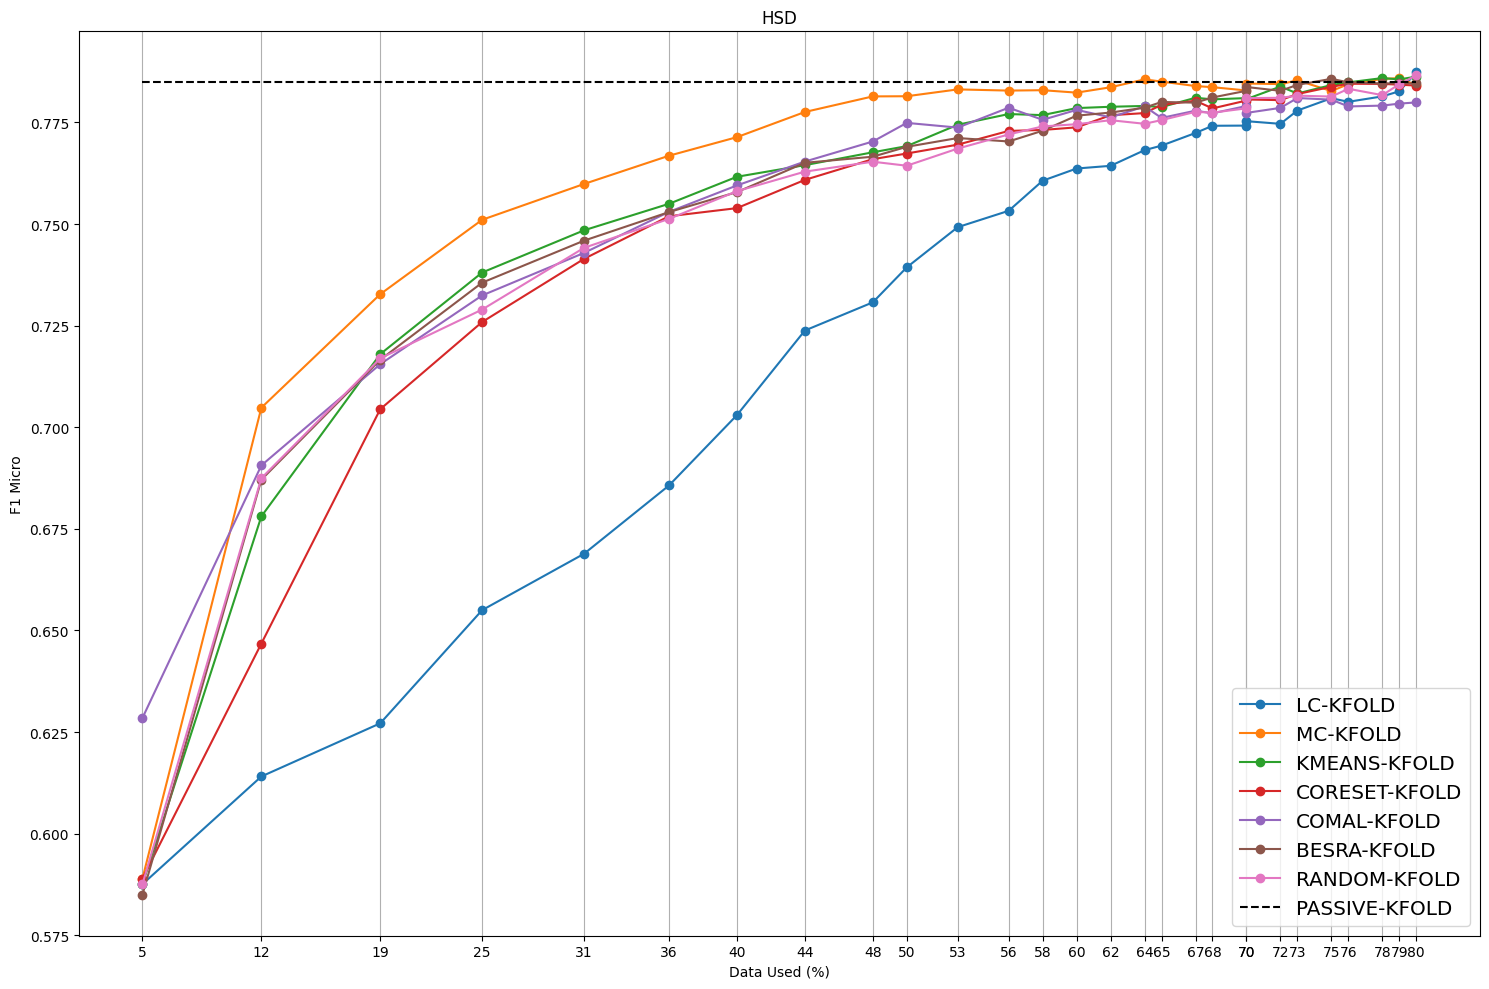

In [23]:
result = load_result('hsd')
plot_results('hsd', result)

LC-KFOLD STD: 0.010274151570423678
    Data Used  Accuracy  F1 Micro  F1 Macro
0       658.0  0.878286  0.587577  0.293711
1      1646.0  0.877139  0.614080  0.319749
2      2535.0  0.878416  0.627161  0.336548
3      3335.2  0.882614  0.655011  0.386170
4      4055.2  0.886006  0.668876  0.394792
5      4703.2  0.891729  0.685678  0.441615
6      5287.2  0.900000  0.702988  0.465990
7      5812.2  0.904898  0.723804  0.499865
8      6285.2  0.907800  0.730736  0.529156
9      6584.0  0.910181  0.739348  0.573660
10     6980.0  0.915079  0.749236  0.591758
11     7336.0  0.914689  0.753262  0.600435
12     7656.0  0.917572  0.760666  0.611749
13     7901.0  0.917770  0.763668  0.611108
14     8165.0  0.919271  0.764329  0.615821
15     8402.2  0.920089  0.768182  0.621860
16     8616.2  0.920926  0.769301  0.623882
17     8816.2  0.922228  0.772410  0.625948
18     9016.2  0.922166  0.774184  0.627268
19     9216.2  0.921999  0.774227  0.628689
20     9218.0  0.921633  0.775313  0.6366

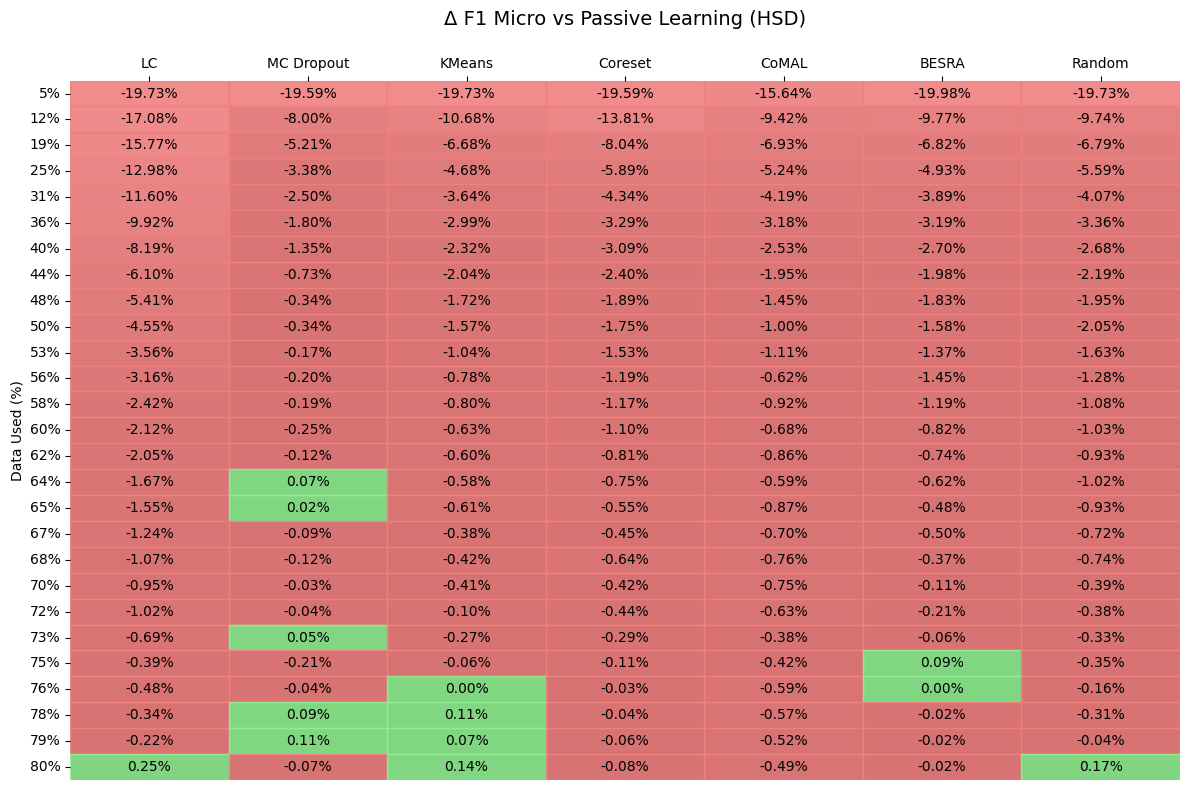

In [24]:
result = load_result('hsd')
df = compare_results(result, num_data['hsd'], 'F1 Micro', 'passive', 0)
plot_tabular_result(df, 'hsd'.upper(), 'Δ F1 Micro vs Passive Learning', 'passive')

LC-KFOLD STD: 0.010274151570423678
    Data Used  Accuracy  F1 Micro  F1 Macro
0       658.0  0.878286  0.587577  0.293711
1      1646.0  0.877139  0.614080  0.319749
2      2535.0  0.878416  0.627161  0.336548
3      3335.2  0.882614  0.655011  0.386170
4      4055.2  0.886006  0.668876  0.394792
5      4703.2  0.891729  0.685678  0.441615
6      5287.2  0.900000  0.702988  0.465990
7      5812.2  0.904898  0.723804  0.499865
8      6285.2  0.907800  0.730736  0.529156
9      6584.0  0.910181  0.739348  0.573660
10     6980.0  0.915079  0.749236  0.591758
11     7336.0  0.914689  0.753262  0.600435
12     7656.0  0.917572  0.760666  0.611749
13     7901.0  0.917770  0.763668  0.611108
14     8165.0  0.919271  0.764329  0.615821
15     8402.2  0.920089  0.768182  0.621860
16     8616.2  0.920926  0.769301  0.623882
17     8816.2  0.922228  0.772410  0.625948
18     9016.2  0.922166  0.774184  0.627268
19     9216.2  0.921999  0.774227  0.628689
20     9218.0  0.921633  0.775313  0.6366

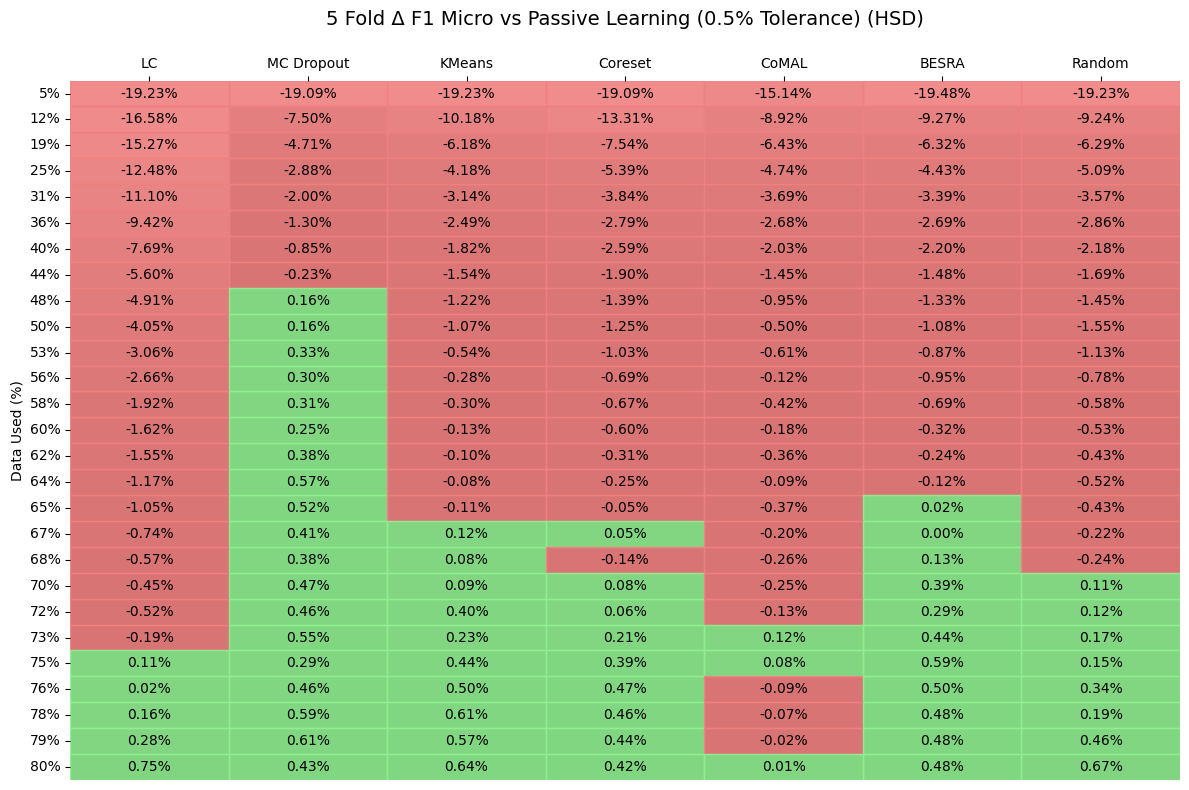

In [25]:
result = load_result('hsd')
df = compare_results(result, num_data['hsd'], 'F1 Micro', 'passive', 0.005)
plot_tabular_result(df, 'hsd'.upper(), '5 Fold Δ F1 Micro vs Passive Learning (0.5% Tolerance)', 'passive')

# NETIFIER

LC-KFOLD STD: 0.011864697975790667
    Data Used  Accuracy  F1 Micro  F1 Macro
0       388.0  0.865969  0.680257  0.671167
1       971.4  0.869000  0.710384  0.703950
2      1496.4  0.870219  0.710436  0.704816
3      1969.4  0.874625  0.724664  0.722560
4      2394.4  0.883000  0.737389  0.733553
5      2777.4  0.888125  0.749221  0.748846
6      3122.4  0.892531  0.762006  0.760772
7      3432.4  0.895906  0.768205  0.766966
8      3711.4  0.897875  0.770947  0.769769
9      3886.0  0.896281  0.771113  0.769624
10     4120.0  0.898375  0.775108  0.774336
11     4330.0  0.901438  0.778648  0.777254
12     4530.0  0.903437  0.779243  0.778119
13     4663.0  0.900750  0.778622  0.778510
14     4863.0  0.904500  0.780403  0.777857
15     5063.0  0.903000  0.779908  0.777807
16     5263.0  0.904469  0.782986  0.781055
17     5441.0  0.904750  0.783965  0.781052
18     5641.0  0.903719  0.782364  0.780358
19     5841.0  0.904719  0.785492  0.783600
20     6041.0  0.904625  0.784332  0.7826

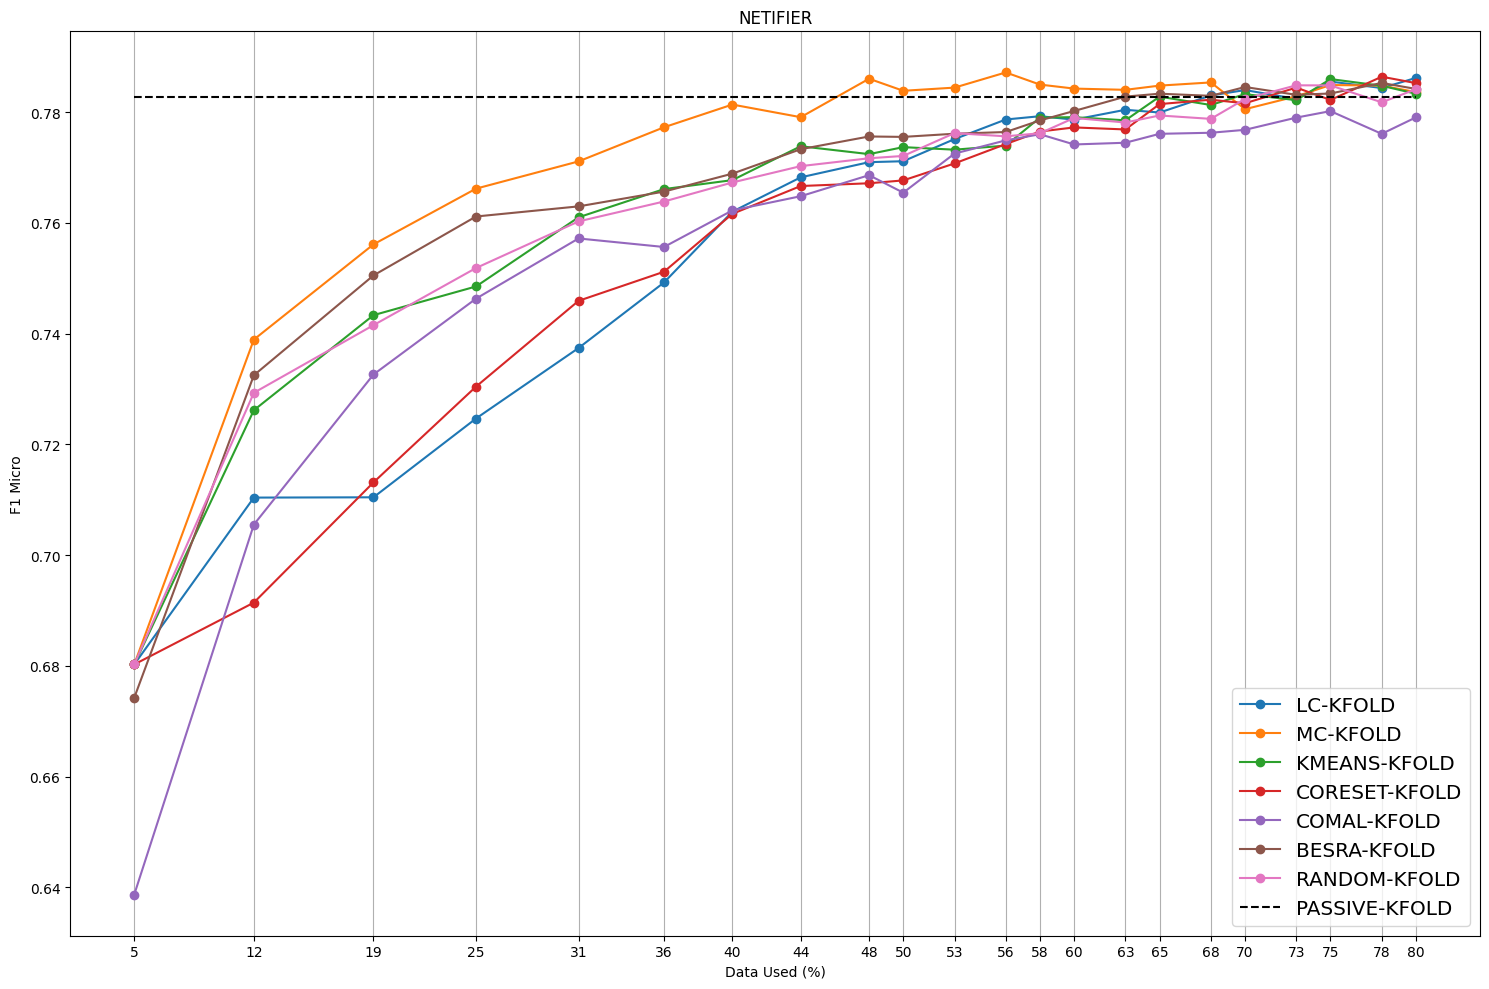

In [26]:
result = load_result('netifier')
plot_results('netifier', result)

LC-KFOLD STD: 0.011864697975790667
    Data Used  Accuracy  F1 Micro  F1 Macro
0       388.0  0.865969  0.680257  0.671167
1       971.4  0.869000  0.710384  0.703950
2      1496.4  0.870219  0.710436  0.704816
3      1969.4  0.874625  0.724664  0.722560
4      2394.4  0.883000  0.737389  0.733553
5      2777.4  0.888125  0.749221  0.748846
6      3122.4  0.892531  0.762006  0.760772
7      3432.4  0.895906  0.768205  0.766966
8      3711.4  0.897875  0.770947  0.769769
9      3886.0  0.896281  0.771113  0.769624
10     4120.0  0.898375  0.775108  0.774336
11     4330.0  0.901438  0.778648  0.777254
12     4530.0  0.903437  0.779243  0.778119
13     4663.0  0.900750  0.778622  0.778510
14     4863.0  0.904500  0.780403  0.777857
15     5063.0  0.903000  0.779908  0.777807
16     5263.0  0.904469  0.782986  0.781055
17     5441.0  0.904750  0.783965  0.781052
18     5641.0  0.903719  0.782364  0.780358
19     5841.0  0.904719  0.785492  0.783600
20     6041.0  0.904625  0.784332  0.7826

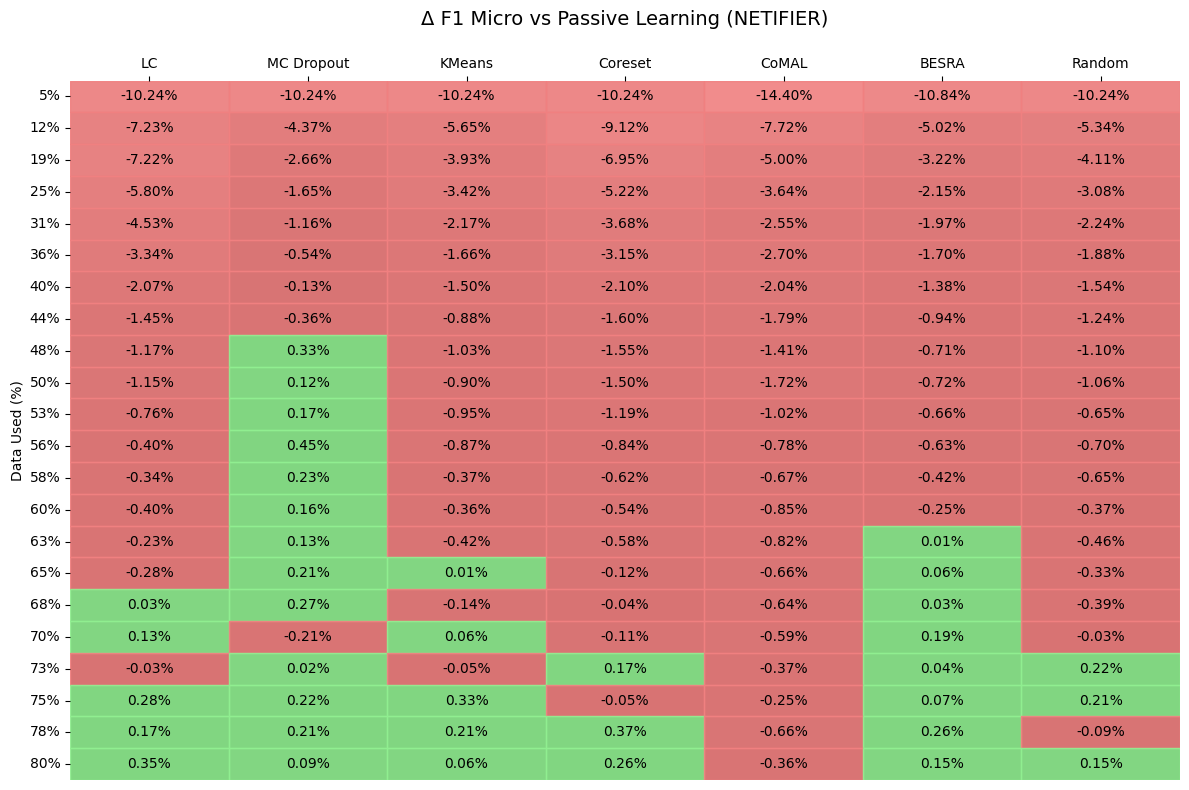

In [ ]:
result = load_result('netifier')
df = compare_results(result, num_data['netifier'], 'F1 Micro', 'passive', 0)
plot_tabular_result(df, 'netifier'.upper(), 'Δ F1 Micro vs Passive Learning', 'passive')

LC-KFOLD STD: 0.011864697975790667
    Data Used  Accuracy  F1 Micro  F1 Macro
0       388.0  0.865969  0.680257  0.671167
1       971.4  0.869000  0.710384  0.703950
2      1496.4  0.870219  0.710436  0.704816
3      1969.4  0.874625  0.724664  0.722560
4      2394.4  0.883000  0.737389  0.733553
5      2777.4  0.888125  0.749221  0.748846
6      3122.4  0.892531  0.762006  0.760772
7      3432.4  0.895906  0.768205  0.766966
8      3711.4  0.897875  0.770947  0.769769
9      3886.0  0.896281  0.771113  0.769624
10     4120.0  0.898375  0.775108  0.774336
11     4330.0  0.901438  0.778648  0.777254
12     4530.0  0.903437  0.779243  0.778119
13     4663.0  0.900750  0.778622  0.778510
14     4863.0  0.904500  0.780403  0.777857
15     5063.0  0.903000  0.779908  0.777807
16     5263.0  0.904469  0.782986  0.781055
17     5441.0  0.904750  0.783965  0.781052
18     5641.0  0.903719  0.782364  0.780358
19     5841.0  0.904719  0.785492  0.783600
20     6041.0  0.904625  0.784332  0.7826

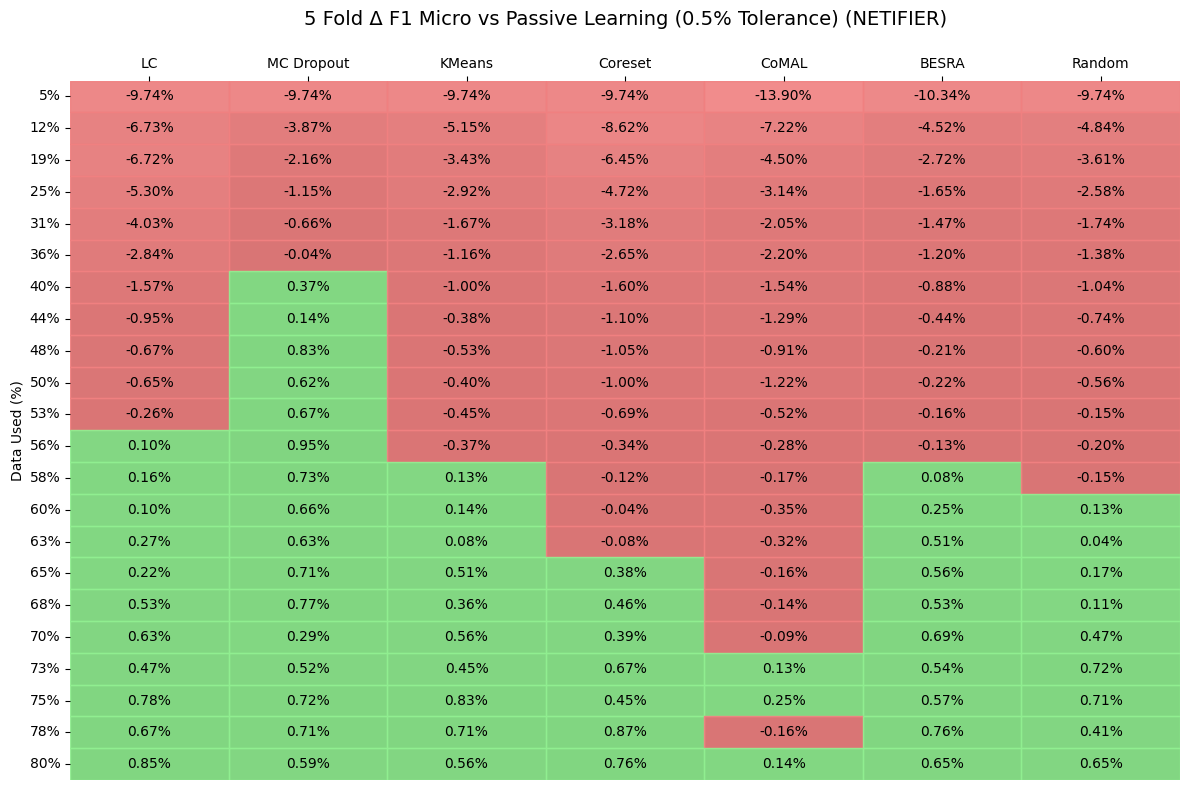

In [29]:
result = load_result('netifier')
df = compare_results(result, num_data['netifier'], 'F1 Micro', 'passive', 0.005)
plot_tabular_result(df, 'netifier'.upper(), '5 Fold Δ F1 Micro vs Passive Learning (0.5% Tolerance)', 'passive')